Based on the Time for Change Model (Abramowitz)

The *Time for Change* Model predicts the incumbent president's popular vote percentage
according to the following pieces of information:
- `NETAPP`	Incumbent president’s net approval rating (approval-dis-approval)
in the final Gallup Poll in June
- `G2GDP`	Annualized growth rate of real GDP in the second quarter of the election year
- `TERM1INC`	Presence (1) or absence (0) of a first-term incumbent in the race
- `A`	Constant = 47.26
- `V`	Incumbent share of the two-party presidential vote

## Vote equation
The model’s vote equation reads as:
```
V = A + 0.108 NETAPP + 0.543 Q2GDP + 4.313 TERM1INC
```

I believe that inflation also needs to be incorporated and that these coefficients might change in midterm years.

In [1]:
# Download GDP Growth Data
import math

import pandas as pd
gdp_growth_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=617&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GDPC1&scale=left&cosd=1947-01-01&coed=2021-10-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=2&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Quarterly&fam=avg&fgst=lin&fgsnd=2009-06-01&line_index=1&transformation=pc1&vintage_date=2022-02-06&revision_date=2022-02-06&nd=1947-01-01'
gdp_growth_csv = pd.read_csv(gdp_growth_url, index_col='DATE')
gdp_growth_csv.rename(columns={'GDPC1_PC1': 'GDP Growth'}, inplace=True)
gdp_growth_csv

,GDP Growth
DATE,
1948-01-01,2.60473
1948-04-01,4.57732
1948-07-01,5.39412
1948-10-01,3.88678
1949-01-01,0.93698
...,...
2020-10-01,-2.26292
2021-01-01,0.54698
2021-04-01,12.22668


In [2]:
# Download inflation data
inflation_url = 'https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=617&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=MEDCPIM158SFRBCLE&scale=left&cosd=1983-01-01&coed=2021-12-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2022-02-06&revision_date=2022-02-06&nd=1983-01-01'
inflation_csv = pd.read_csv(inflation_url, index_col='DATE')
inflation_csv = inflation_csv.rename(columns={'MEDCPIM158SFRBCLE':'Monthly Inflation YoY'})
inflation_csv = inflation_csv['Monthly Inflation YoY']
inflation_csv

DATE
1983-01-01    5.014653
1983-02-01    4.952545
1983-03-01    3.612261
1983-04-01    4.828054
1983-05-01    3.767326
                ...   
2021-08-01    4.025523
2021-09-01    4.968839
2021-10-01    6.251637
2021-11-01    5.855760
2021-12-01    5.275819
Name: Monthly Inflation YoY, Length: 468, dtype: float64

In [3]:
# Download Presidential Favorability
import requests
import json

import itertools
approval_url = 'https://news.gallup.com/wwwv7interactives/json/ALLPRESIDENTS/codename.aspx?'
approval_json = json.loads(requests.get(approval_url).text)
approval_data = approval_json['AllPresidents']['HistoricalPresident'][0]['data']['Row']
historical_df = pd.DataFrame(list(itertools.chain(*[pres['data']['Row'] for pres in approval_json['AllPresidents']['HistoricalPresident']])))
historical_df

,StartDate,EndDate,DaysInOffice,Approve,Disapprove,Rep,Dem,Ind
0,2009-01-09,2009-01-11,"2911,2912,2913",34,61,75,6,28
1,2008-12-12,2008-12-14,"2883,2884,2885",29,67,67,7,25
2,2008-12-04,2008-12-07,"2875,2876,2877,2878",32,61,72,9,26
3,2008-11-13,2008-11-16,"2854,2855,2856,2857",29,66,66,6,28
4,2008-11-07,2008-11-09,"2848,2849,2850",28,68,63,5,21
...,...,...,...,...,...,...,...,...
1276,1946-02-28,1946-03-05,"322,323,324,325,326,327",49,38,-,-,-
1277,1946-01-05,1946-01-10,"268,269,270,271,272,273",63,22,-,-,-
1278,1945-11-02,1945-11-07,"204,205,206,207,208,209",75,14,-,-,-
1279,1945-10-05,1945-10-10,"176,177,178,179,180,181",82,9,-,-,-


In [4]:
obama_url = 'https://news.gallup.com/wwwv7interactives/json/OBAMAEXPANDED/codename.aspx?'
obama_json = json.loads(requests.get(obama_url).text)
obama_data = [{'StartDate':date['startDate'],'EndDate':date['endDate'],'Approve':int(date['Overall']['A']),'Disapprove':int(date['Overall']['D'])} for date in obama_json['ExpandedDemographics']['data']['date']]
obama_df = pd.DataFrame(obama_data)
obama_df

,StartDate,EndDate,Approve,Disapprove
0,2017-01-16,2017-01-19,59,37
1,2017-01-09,2017-01-15,57,39
2,2017-01-02,2017-01-08,55,42
3,2016-12-26,2017-01-01,55,40
4,2016-12-19,2016-12-25,56,40
...,...,...,...,...
413,2009-02-16,2009-02-22,62,25
414,2009-02-09,2009-02-15,64,22
415,2009-02-02,2009-02-08,65,21
416,2009-01-26,2009-02-01,66,18


In [5]:
trump_url = 'https://news.gallup.com/wwwv7interactives/json/TRUMPEXPANDED/codename.aspx?'
trump_json = json.loads(requests.get(trump_url).text)
trump_data = [{'StartDate':date['startDate'],'EndDate':date['endDate'],'Approve':int(date['Overall']['A']),'Disapprove':int(date['Overall']['D'])} for date in trump_json['ExpandedDemographics']['data']['date']]
trump_df = pd.DataFrame(trump_data)
trump_df

,StartDate,EndDate,Approve,Disapprove
0,2021-01-04,2021-01-15,34,62
1,2020-12-01,2020-12-17,39,57
2,2020-11-05,2020-11-19,43,55
3,2020-09-30,2020-10-27,45,54
4,2020-08-31,2020-09-28,44,54
5,2020-07-30,2020-08-12,42,55
6,2020-07-01,2020-07-23,41,56
7,2020-05-28,2020-06-30,39,57
8,2020-05-01,2020-05-13,49,48
9,2020-04-01,2020-04-28,46,50


In [6]:
biden_url = 'https://news.gallup.com/wwwv7interactives/json/CURRENTPRESWEEKLY/codename.aspx?'
biden_json = json.loads(requests.get(biden_url).text)
biden_data =[{'StartDate':date['startDate'],'EndDate':date['endDate'],'Approve':int(date['Overall']['A']),'Disapprove':int(date['Overall']['D'])} for date in biden_json['CurrentPresident']['data']['date']]
biden_df = pd.DataFrame(biden_data)
biden_df

,StartDate,EndDate,Approve,Disapprove
0,2022-01-03,2022-01-16,40,56
1,2021-12-01,2021-12-16,43,51
2,2021-11-01,2021-11-16,42,55
3,2021-10-01,2021-10-19,42,52
4,2021-09-01,2021-09-17,43,55
5,2021-08-02,2021-08-17,49,48
6,2021-07-06,2021-07-21,50,45
7,2021-06-01,2021-06-18,56,42
8,2021-05-03,2021-05-18,54,40
9,2021-04-01,2021-04-21,57,40


In [7]:
combined_approval = pd.concat([biden_df, trump_df, obama_df, historical_df], join='inner', ignore_index=True)
combined_approval

,StartDate,EndDate,Approve,Disapprove
0,2022-01-03,2022-01-16,40,56
1,2021-12-01,2021-12-16,43,51
2,2021-11-01,2021-11-16,42,55
3,2021-10-01,2021-10-19,42,52
4,2021-09-01,2021-09-17,43,55
...,...,...,...,...
1755,1946-02-28,1946-03-05,49,38
1756,1946-01-05,1946-01-10,63,22
1757,1945-11-02,1945-11-07,75,14
1758,1945-10-05,1945-10-10,82,9


In [8]:
combined_approval['Approve'] = combined_approval['Approve'].apply(int)
combined_approval['Disapprove'] = combined_approval['Disapprove'].apply(int)

In [9]:
combined_approval['Net'] = combined_approval['Approve'] - combined_approval['Disapprove']
combined_approval

,StartDate,EndDate,Approve,Disapprove,Net
0,2022-01-03,2022-01-16,40,56,-16
1,2021-12-01,2021-12-16,43,51,-8
2,2021-11-01,2021-11-16,42,55,-13
3,2021-10-01,2021-10-19,42,52,-10
4,2021-09-01,2021-09-17,43,55,-12
...,...,...,...,...,...
1755,1946-02-28,1946-03-05,49,38,11
1756,1946-01-05,1946-01-10,63,22,41
1757,1945-11-02,1945-11-07,75,14,61
1758,1945-10-05,1945-10-10,82,9,73


In [10]:
# Download the popular vote results
# Results come from here:
popular_vote_url = 'https://en.wikipedia.org/wiki/List_of_United_States_presidential_elections_by_popular_vote_margin'
# But it was easier to just modify the table by hand, so it's saved in `data/national_election_winners.csv`

In [11]:
national_elections = pd.read_csv('data/national_election_winners.csv', index_col='Year')
national_elections

,Election,Winner,Winner Party,EC Votes,EC %,PV %,PV % Margin,PV Votes,PV Margin,Runner-up,Runner-up Party,Turnout
Year,,,,,,,,,,,,
1788,1,George Washington,Ind.,69/69,1.0000,1.0000,1.0000,43782,43782,No candidate[a],No candidate[a],0.116
1792,2,George Washington,Ind.,132/132,1.0000,1.0000,1.0000,28579,28579,No candidate[a],No candidate[a],0.063
1796,3,John Adams,Fed.,71/138,0.5145,0.5345,0.0690,35726,4611,Thomas Jefferson,D-R[b],0.201
1800,4,Thomas Jefferson,D-R,73/138,0.5290,0.6143,0.2286,41330,15378,Aaron Burr,D-R[c],0.323
1804,5,Thomas Jefferson,D-R,162/176,0.9205,0.7279,0.4558,104110,65191,Charles C. Pinckney,Fed.,0.238
1808,6,James Madison,D-R,122/175,0.6972,0.6474,0.3233,124732,62301,Charles C. Pinckney,Fed.,0.368
1812,7,James Madison,D-R,128/217,0.5899,0.5037,0.0274,140431,7650,DeWitt Clinton,D-R[d],0.404
1816,8,James Monroe,D-R,183/217,0.8433,0.6816,0.3724,76592,41852,Rufus King,Fed.,0.235
1820,9,James Monroe,D-R,231/232,0.9957,0.8061,0.6469,87343,69878,John Quincy Adams,D-R[e],0.101


In [36]:
house_url = 'https://en.wikipedia.org/wiki/List_of_United_States_House_of_Representatives_elections,_1856%E2%80%93present'
# Again this is just easier for me to download ahead of time an manipulate in excel.
house_results = pd.read_csv('data/house_results.csv', index_col='ElectionYear')

In [59]:
from typing import Dict
def get_data_for_year(year: int)->Dict:
    n = 100
    gdp = gdp_growth_csv['GDP Growth'][f'{year}-04-01']
    june_polls = combined_approval.loc[combined_approval['StartDate'].str.contains(f'{year}-06')]
    if not len(june_polls):
        # Use July
        june_polls = combined_approval.loc[combined_approval['StartDate'].str.contains(f'{year}-07')]
    net_approval = june_polls['Net'].iloc[0]
    try:
        pop_vote = round(national_elections['PV %'][year] * n)
    except KeyError:
        pop_vote = math.nan
    if year%4 == 0:
        # Presidential Year
        incumbent = 1 if national_elections['Winner'][year-4] != national_elections['Winner'][year-8] else 0
    else:
        incumbent = .5 if national_elections['Winner'][year-2] != national_elections['Winner'][year-6] else 0
    time_for_change = 47.26 + .108*net_approval + .543*gdp + 4.313*incumbent
    months_for_inflation_calc = ('01','02','03','04','05','06','07','08','09')
    try:
        inflation_mean = sum(inflation_csv[f'{year}-{month}-01'] for month in months_for_inflation_calc)/len(months_for_inflation_calc)
    except KeyError:
        inflation_mean = math.nan
    try:
        means = summary['mean']
        updated_model_prediction = means['Intercept'] + means['GDP']*gdp +means['Net Approval']*net_approval + means['Incumbent']*incumbent
    except Exception:
        updated_model_prediction = 49.422 + 0.096*gdp +0.086*net_approval + 2.446*incumbent
    house_incumbent_result = 100 * house_results['Percentage Incumbent Seats after Election'][year]
    midterm_year = int((year%4)/2)
    return {'GDP':gdp,
            'Net Approval': net_approval,
            'Result': pop_vote,
            'Incumbent': incumbent,
            'n':n,
            'Time For Change Prediction': time_for_change,
            'Updated Prediction': updated_model_prediction,
            'Avg Inflation': inflation_mean,
            'House Incumbent Percent': house_incumbent_result,
            'Midterm Year': midterm_year}
get_data_for_year(2016)

{'GDP': 1.36763,
 'Net Approval': 6,
 'Result': 46,
 'Incumbent': 0,
 'n': 100,
 'Time For Change Prediction': 48.65062309,
 'Updated Prediction': 51.23832254,
 'Avg Inflation': 2.712065335538126,
 'House Incumbent Percent': 55.402298900000005,
 'Midterm Year': 0}

In [60]:
years_range = range(1948,2022,2)
compiled_data = pd.DataFrame([get_data_for_year(year) for year in years_range], index=years_range)
compiled_data['Avg Inflation'] = compiled_data['Avg Inflation'].astype('float')
compiled_data

,GDP,Net Approval,Result,Incumbent,n,Time For Change Prediction,Updated Prediction,Avg Inflation,House Incumbent Percent,Midterm Year
1948,4.57732,-4,50.0,0.0,100,49.313485,50.514485,NaN,39.310345,0
1950,7.29736,-10,NaN,0.5,100,52.298966,50.481747,NaN,54.022989,1
1952,3.60142,-26,55.0,1.0,100,50.720571,49.166882,NaN,48.965517,0
1954,-2.43001,38,NaN,0.5,100,52.201005,54.285559,NaN,46.666667,1
1956,2.40215,55,57.0,1.0,100,58.817367,56.468325,NaN,53.333333,0
1958,-2.01841,31,NaN,0.0,100,49.512003,53.316932,NaN,64.908257,1
1960,2.05821,30,50.0,0.0,100,51.617608,53.462376,NaN,60.411899,0
1962,6.72769,50,NaN,0.5,100,58.469636,55.908706,NaN,59.540230,1
1964,6.18075,59,61.0,1.0,100,61.301147,57.051483,NaN,67.816092,0
1966,7.49014,9,NaN,0.5,100,54.455646,52.221928,NaN,57.011494,1


In [39]:
compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])

0.631578947368421

In [15]:
from bambi import Model, Prior
priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent']))}
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
model = Model('Result ~ GDP + "Net Approval" + Incumbent', compiled_data, priors=priors, dropna=True)
model

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Formula: Result ~ GDP + "Net Approval" + Incumbent
Family name: Gaussian
Link: identity
Observations: 19
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 51.6842, sigma: 17.1472)
    GDP ~ Normal(mu: 0.0, sigma: 3.5815)
    Net Approval ~ Normal(mu: 0.0, sigma: 0.5082)
    Incumbent ~ Bernoulli(p: 0.6316)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 5.0477)

In [16]:
model_results = model.fit(draws=5000)
model_results

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Result_sigma, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 9 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'Net Approval'}>],
       [<AxesSubplot:title={'center':'Incumbent'}>,
        <AxesSubplot:title={'center':'Result_sigma'}>, <AxesSubplot:>]],
      dtype=object)

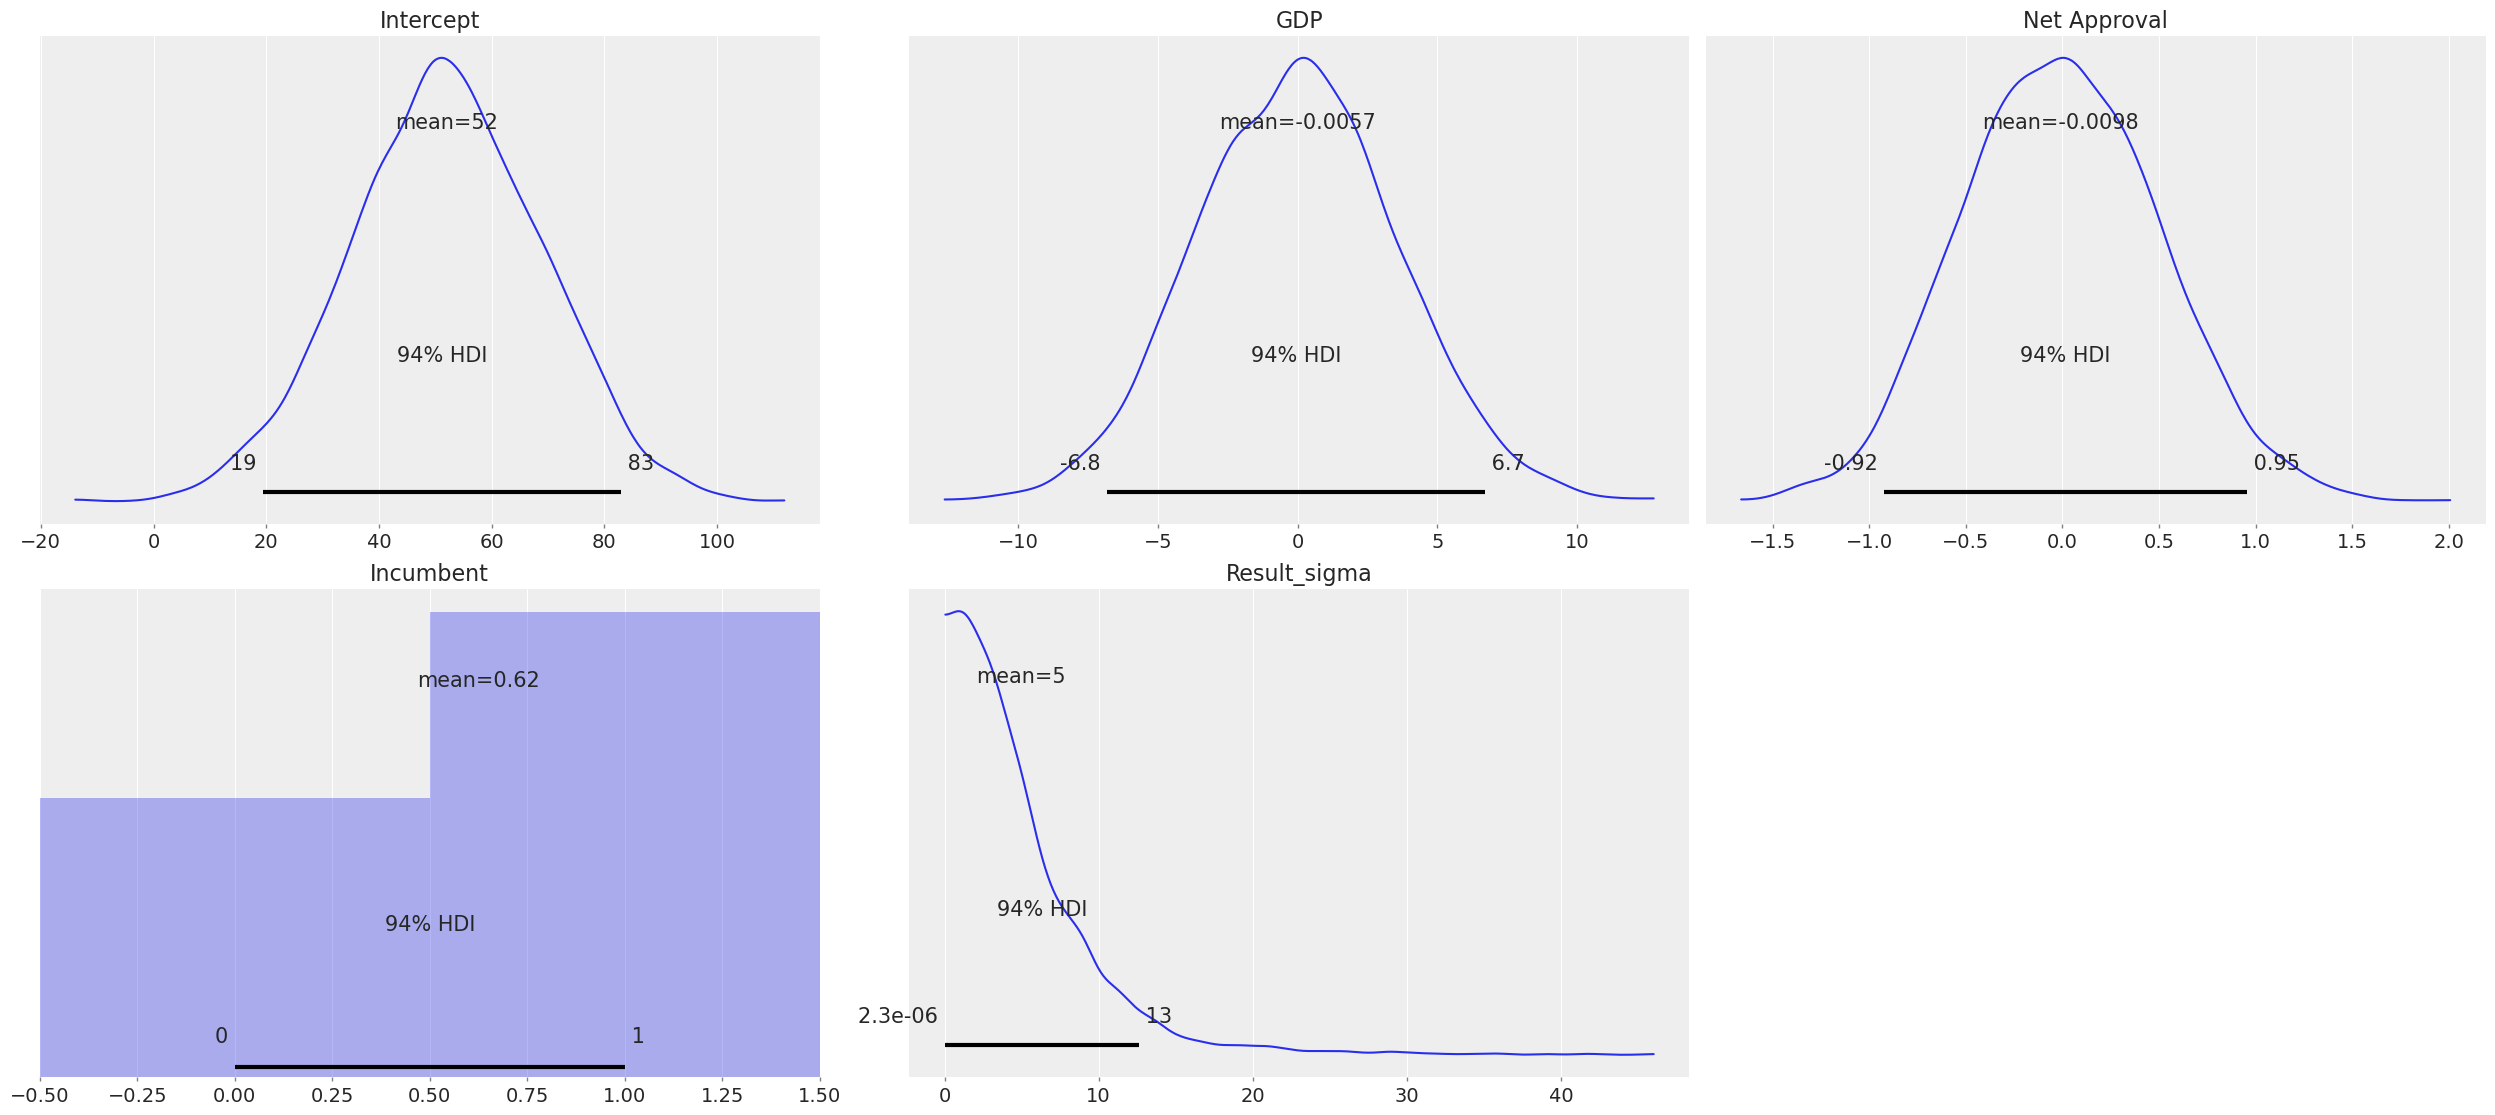

In [17]:
import arviz as az
az.style.use('arviz-darkgrid')
model.plot_priors()

array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'GDP'}>,
        <AxesSubplot:title={'center':'GDP'}>],
       [<AxesSubplot:title={'center':'Net Approval'}>,
        <AxesSubplot:title={'center':'Net Approval'}>],
       [<AxesSubplot:title={'center':'Incumbent'}>,
        <AxesSubplot:title={'center':'Incumbent'}>],
       [<AxesSubplot:title={'center':'Result_sigma'}>,
        <AxesSubplot:title={'center':'Result_sigma'}>]], dtype=object)

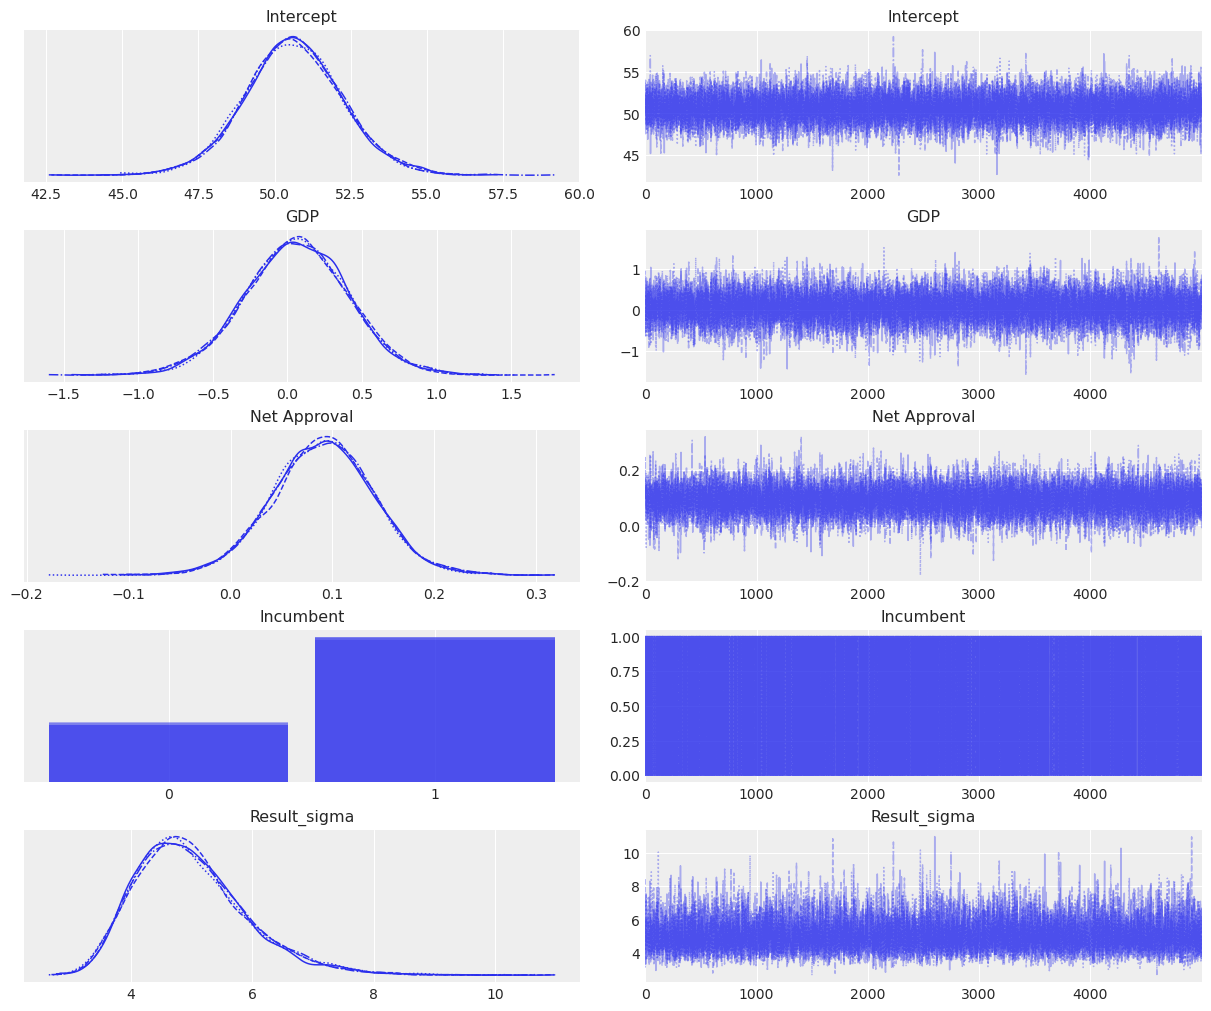

In [18]:
az.plot_trace(model_results)

In [19]:
summary = az.summary(model_results)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,50.613,1.612,47.606,53.709,0.011,0.008,20095.0,14251.0,1.0
GDP,0.058,0.352,-0.597,0.728,0.003,0.002,16301.0,13533.0,1.0
Net Approval,0.091,0.050,-0.007,0.180,0.000,0.000,15731.0,13324.0,1.0
Incumbent,0.711,0.453,0.000,1.000,0.003,0.002,26792.0,20000.0,1.0
Result_sigma,4.997,0.927,3.439,6.737,0.008,0.006,13819.0,11706.0,1.0


## Vote equation
The model’s vote equation reads as:
```
V = A + 0.108 NETAPP + 0.543 Q2GDP + 4.313 TERM1INC
A = 47.26
```



In [20]:
summary['mean']

Intercept       50.613
GDP              0.058
Net Approval     0.091
Incumbent        0.711
Result_sigma     4.997
Name: mean, dtype: float64

In [21]:
means = summary['mean']
compiled_data['Updated Prediction'] = means['Intercept'] + means['GDP']*compiled_data['GDP'] +means['Net Approval']*compiled_data['Net Approval'] + means['Incumbent']*compiled_data['Incumbent']

compiled_data['Updated Prediction']

1948    50.514485
1952    49.166882
1956    56.468325
1960    53.462376
1964    57.051483
1968    51.006904
1972    53.721801
1976    51.426010
1980    48.822047
1984    53.243809
1988    51.601107
1992    49.960846
1996    52.466124
2000    52.282191
2004    51.478619
2008    47.053048
2012    51.552682
2016    51.238323
2020    49.614143
Name: Updated Prediction, dtype: float64

In [84]:
from sklearn.metrics import mean_squared_error
result_not_null = compiled_data[compiled_data['Result'].notnull()]
tfc_mse = mean_squared_error(result_not_null['Result'], result_not_null['Time For Change Prediction'], squared=False)
updated_mse = mean_squared_error(result_not_null['Result'], result_not_null['Updated Prediction'], squared=False)
print({'Time for Change': tfc_mse, 'Updated Prediction': updated_mse})

{'Time for Change': 4.77392370390397, 'Updated Prediction': 4.383988410451002}


Our updated model is *slightly* more accurate, but note that the original model is within the confidence interval of ours.

In [85]:
compiled_data['Avg Inflation']

1948         NaN
1950         NaN
1952         NaN
1954         NaN
1956         NaN
1958         NaN
1960         NaN
1962         NaN
1964         NaN
1966         NaN
1968         NaN
1970         NaN
1972         NaN
1974         NaN
1976         NaN
1978         NaN
1980         NaN
1982         NaN
1984    4.410858
1986    3.676793
1988    4.258259
1990    4.904681
1992    2.598735
1994    2.904296
1996    2.970630
1998    2.880526
2000    3.078659
2002    2.651725
2004    2.570994
2006    3.132790
2008    3.115855
2010    0.542147
2012    2.226265
2014    2.197790
2016    2.712065
2018    2.674912
2020    2.606806
Name: Avg Inflation, dtype: float64

Automatically removing 9/19 rows from the dataset.


Formula: Result ~ GDP + "Net Approval" + Incumbent + "Avg Inflation"
Family name: T
Link: identity
Observations: 10
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 50.4, sigma: 10.3199)
    GDP ~ Normal(mu: 3.1662, sigma: 3.62)
    Net Approval ~ Normal(mu: 4.8947, sigma: 25.5123)
    Incumbent ~ Bernoulli(p: 0.6316)
    Avg Inflation ~ Normal(mu: -3.0549, sigma: 0.7261)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 4.128)
    nu ~ Gamma(alpha: 2, beta: 0.1)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [Result_nu, Result_sigma, Avg Inflation, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,40.085,2.619,35.108,45.027,0.019,0.014,18320.0,14134.0,1.0
GDP,0.021,0.370,-0.660,0.730,0.003,0.003,14817.0,12216.0,1.0
Net Approval,-0.021,0.095,-0.197,0.162,0.001,0.001,13839.0,12196.0,1.0
Incumbent,0.704,0.457,0.000,1.000,0.003,0.002,25276.0,20000.0,1.0
Avg Inflation,-3.219,0.683,-4.503,-1.941,0.005,0.004,17063.0,13524.0,1.0
Result_sigma,3.820,1.175,1.939,6.065,0.011,0.008,10445.0,8345.0,1.0
Result_nu,20.485,14.219,1.307,46.363,0.112,0.079,12642.0,9050.0,1.0


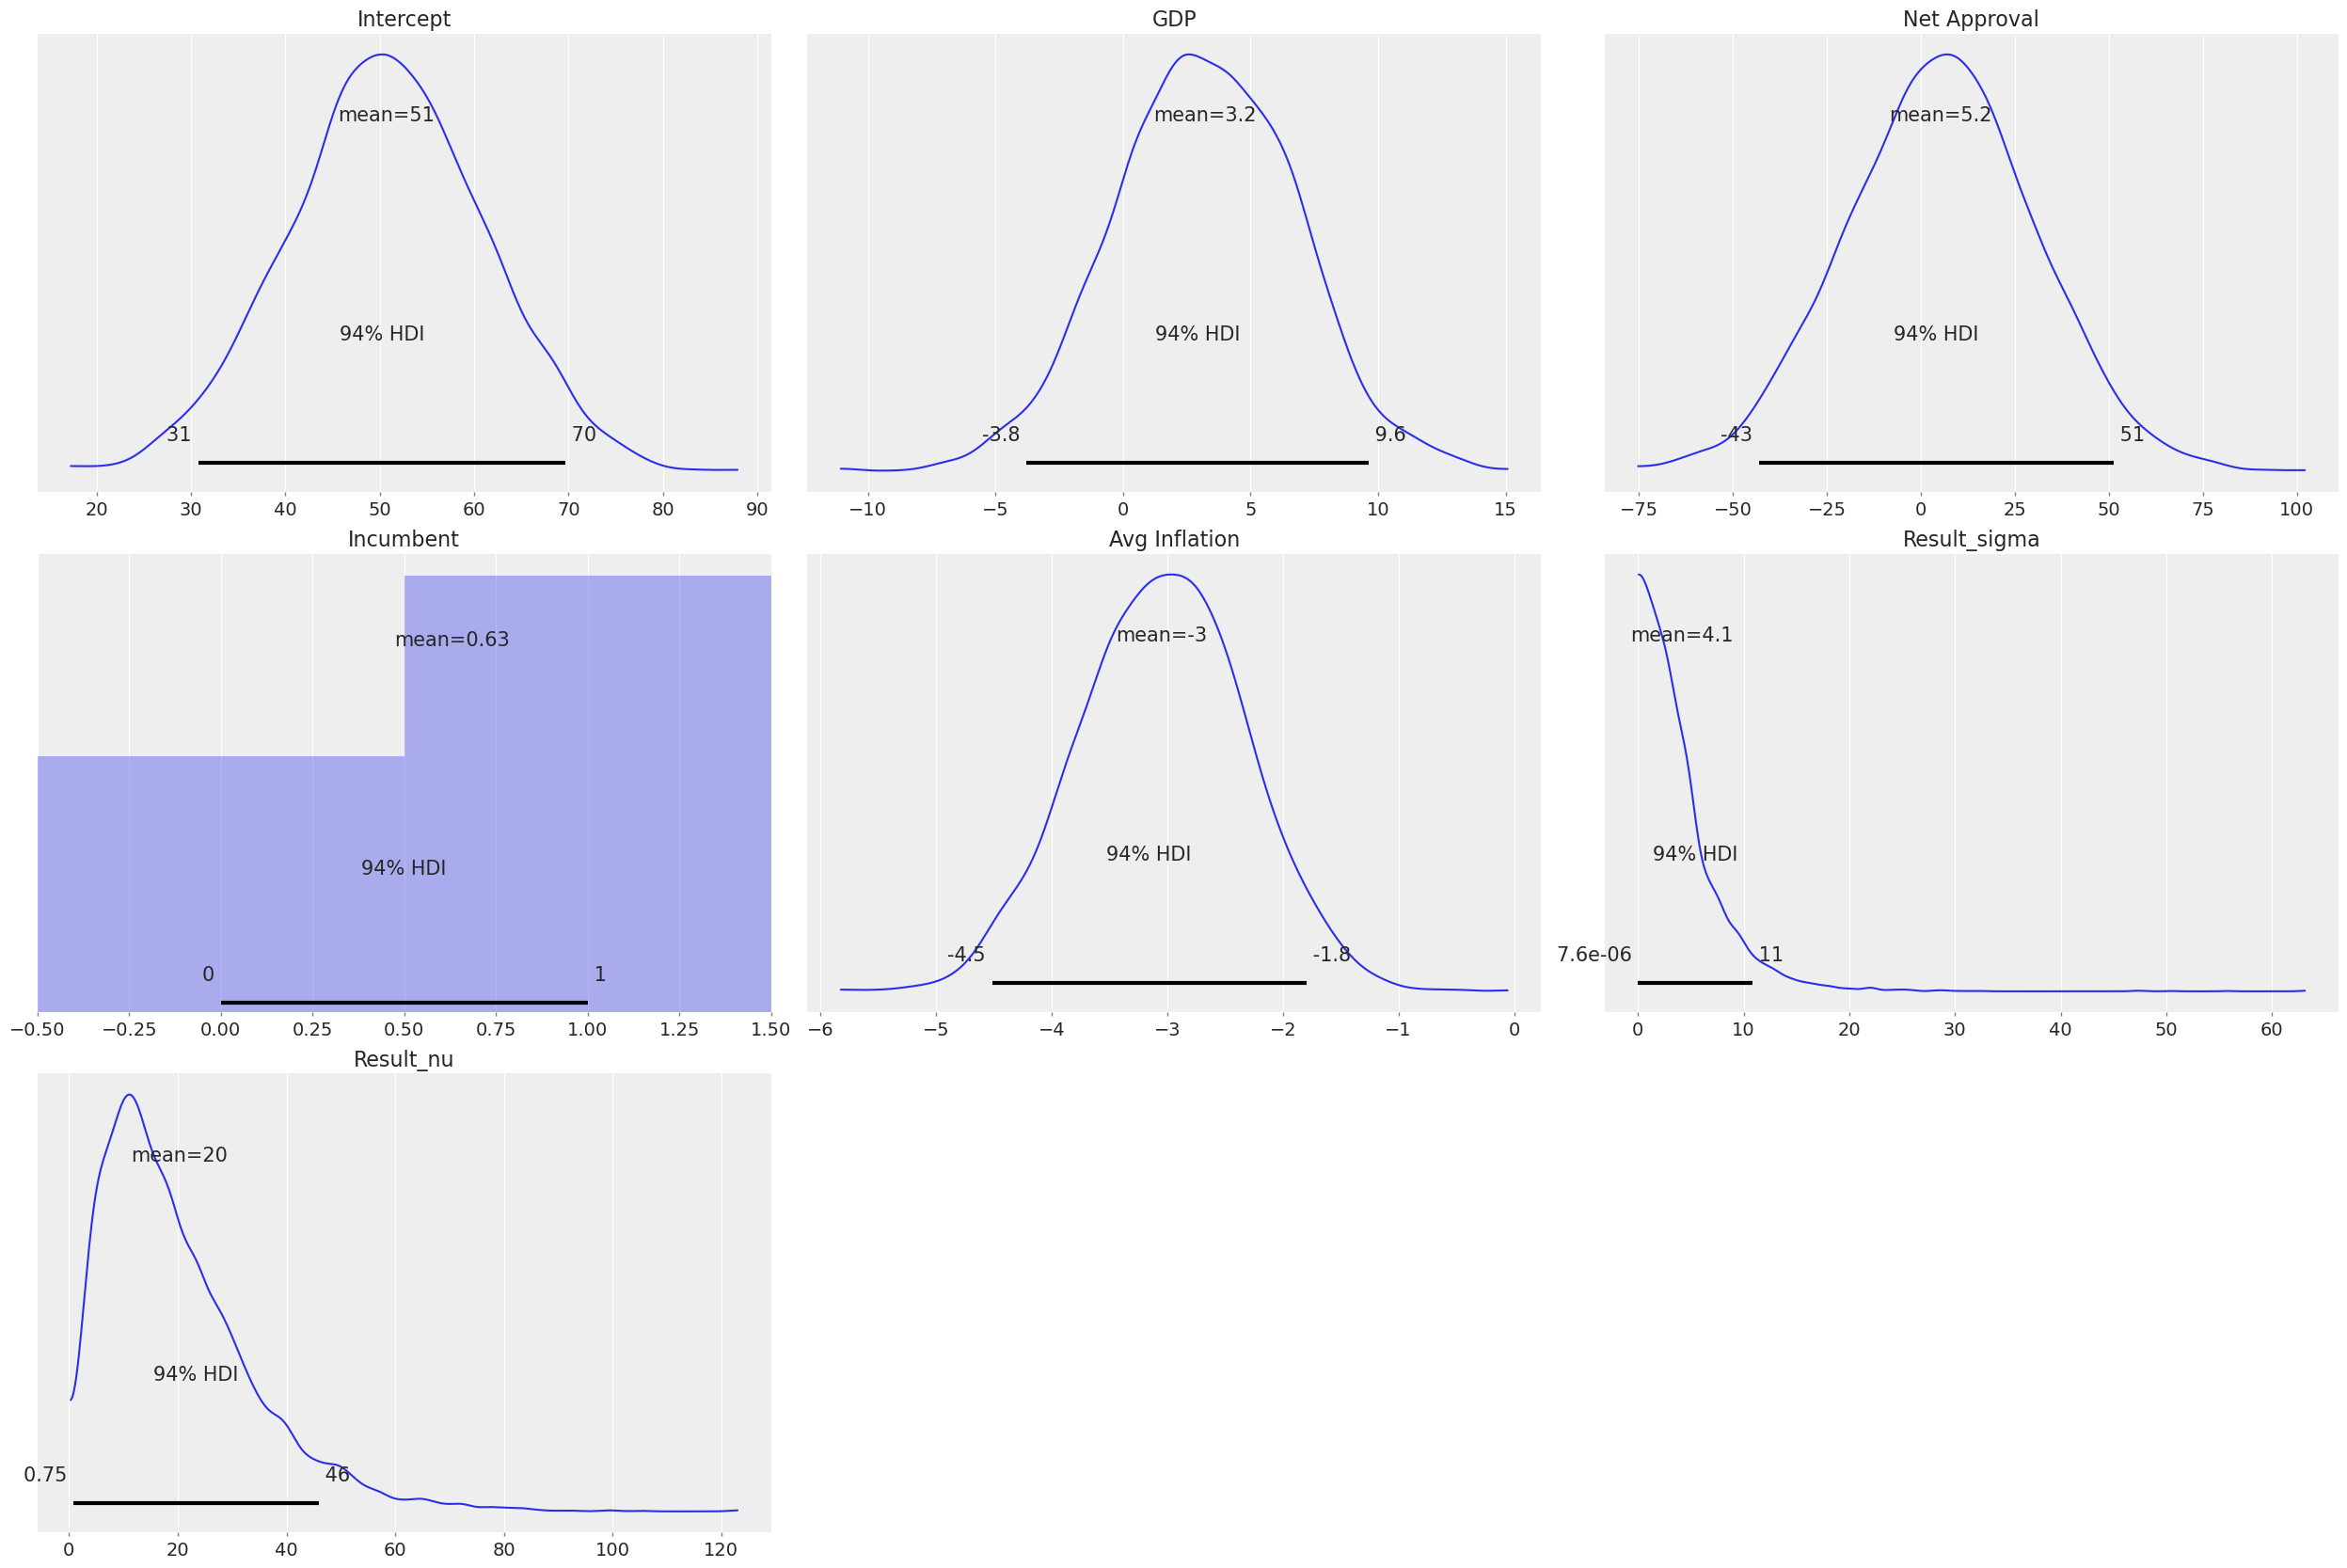

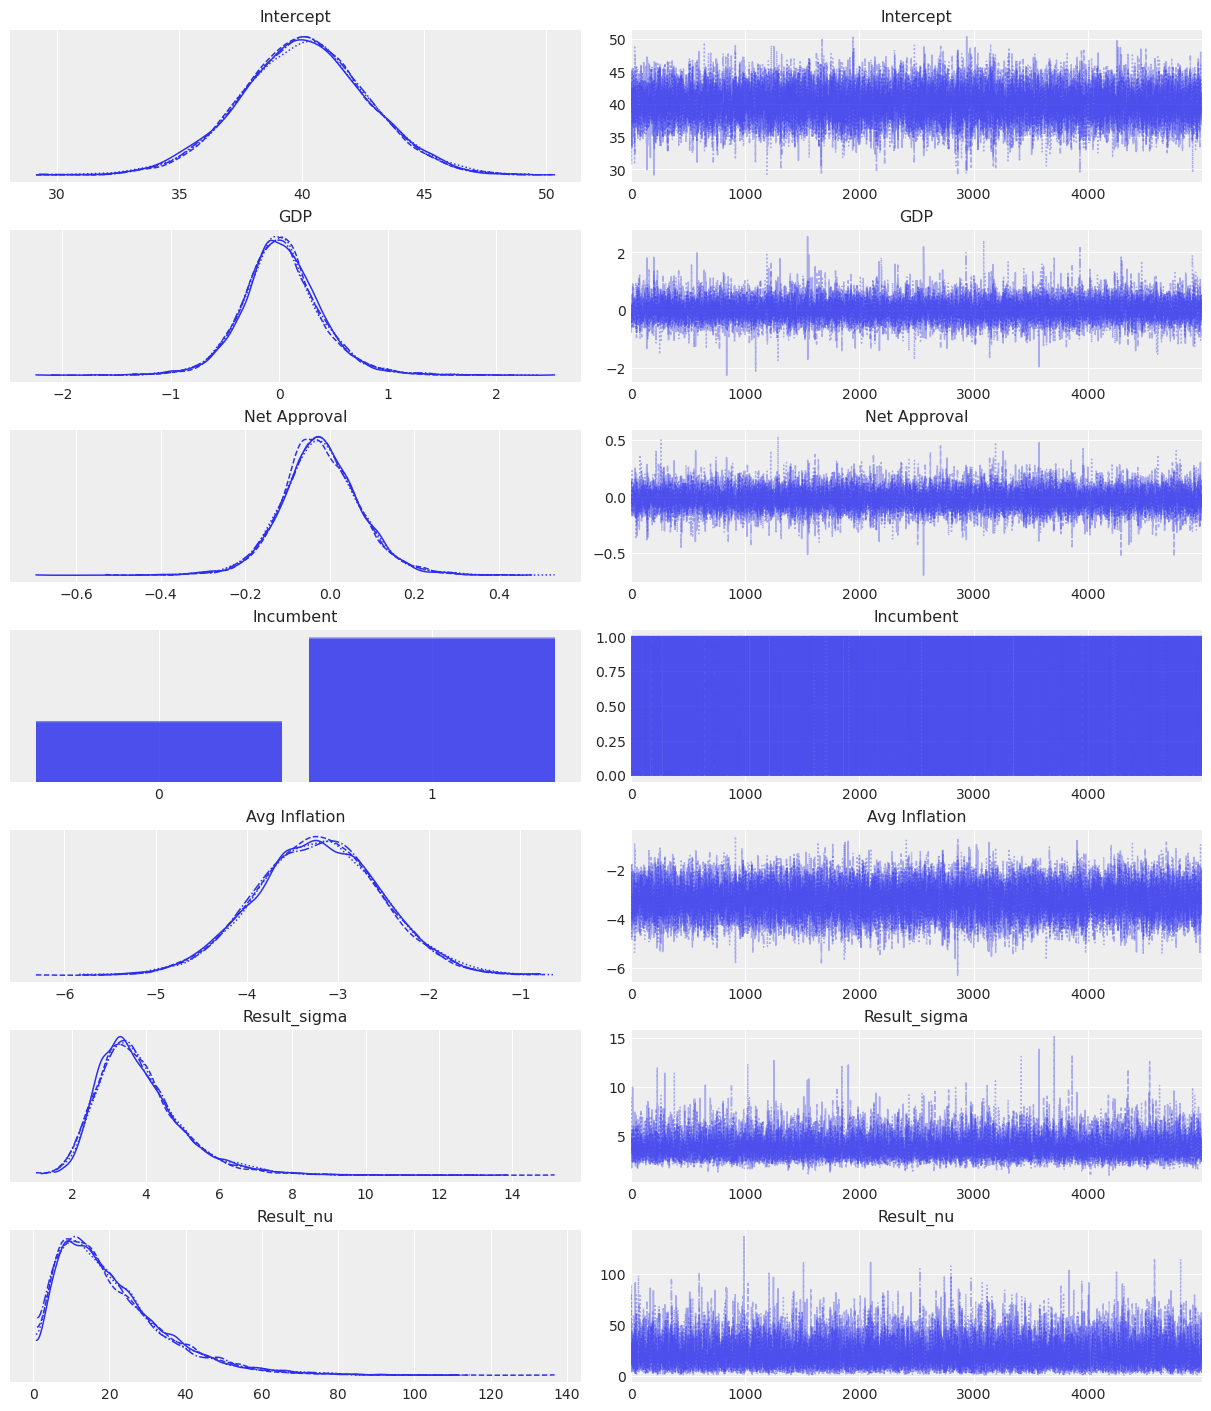

In [31]:
from bambi import Model, Prior
def normal_prior(name):
    return Prior('Normal', mu=compiled_data[name].mean(), sigma=compiled_data[name].std())

inflation_priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])),
                    'GDP': normal_prior('GDP'),
                    "Net Approval": normal_prior("Net Approval"),
                    'Avg Inflation': normal_prior('Avg Inflation'),
                    }
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
inflation_model = Model('Result ~ GDP + "Net Approval" + Incumbent + "Avg Inflation"', compiled_data, priors=inflation_priors, dropna=True, family='t')
print(inflation_model)
inflation_model_results = inflation_model.fit(draws=5000)
print(inflation_model_results)
inflation_model.plot_priors()
az.plot_trace(inflation_model_results)
inflation_summary = az.summary(inflation_model_results)
inflation_summary

In [89]:
inflation_means = inflation_summary['mean']
compiled_data['Inflation Prediction'] = inflation_means['Intercept'] + inflation_means['GDP']*compiled_data['GDP'] +inflation_means['Net Approval']*compiled_data['Net Approval'] + inflation_means['Incumbent']*compiled_data['Incumbent']

compiled_data['Inflation Prediction']

1948    40.265124
1950    40.800245
1952    41.410630
1954    39.587970
1956    39.684445
1958    39.391613
1960    39.498222
1962    39.528281
1964    39.679796
1966    40.405293
1968    41.051827
1970    39.936420
1972    40.416359
1974    40.710623
1976    40.109624
1978    40.564641
1980    41.339724
1982    40.457778
1984    40.620931
1986    39.364733
1988    40.011177
1990    39.395668
1992    41.212565
1994    40.588733
1996    40.663045
1998    39.625010
2000    39.880138
2002    39.267780
2004    40.898931
2006    40.630523
2008    40.953983
2010    40.477477
2012    40.817850
2014    40.325492
2016    39.987720
2018    40.779219
2020    40.871241
Name: Inflation Prediction, dtype: float64

In [90]:
from sklearn.metrics import mean_squared_error
result_not_null = compiled_data[compiled_data['Result'].notnull()]
tfc_mse = mean_squared_error(result_not_null['Result'], result_not_null['Time For Change Prediction'], squared=False)
updated_mse = mean_squared_error(result_not_null['Result'], result_not_null['Inflation Prediction'], squared=False)
print({'Time for Change': tfc_mse, 'Inflation Prediction': updated_mse})

{'Time for Change': 4.77392370390397, 'Inflation Prediction': 12.348903601636573}


Clearly, inflation does not help us predict better using a bayesian linear model.

Not shown here are some manipulations on inflation experimenting to see if they make a better prior.

All are equally bad or worse.


# House percentage (Including Mid-term election results)
Obviously, there are no presidential elections in mid-term years (hence "mid-term"). To overcome this, we will
predict the percentage of house seats won based on the same priors as above.

Formula: "House Incumbent Percent" ~ GDP + "Net Approval" + Incumbent + "Midterm Year"
Family name: T
Link: identity
Observations: 37
Priors:
  Common-level effects
    Intercept ~ Normal(mu: 55.5585, sigma: 16.5351)
    GDP ~ Normal(mu: 2.9637, sigma: 3.3091)
    Net Approval ~ Normal(mu: 8.8919, sigma: 26.1797)
    Incumbent ~ Bernoulli(p: 0.4865)
    Midterm Year ~ Bernoulli(p: 0.5)

  Auxiliary parameters
    sigma ~ HalfStudentT(nu: 4, sigma: 6.614)
    nu ~ Gamma(alpha: 2, beta: 0.1)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [House Incumbent Percent_nu, House Incumbent Percent_sigma, Net Approval, GDP, Intercept]
>BinaryGibbsMetropolis: [Incumbent, Midterm Year]


/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/opt/homebrew/Caskroom/miniforge/base/envs/ElectionForecasting/lib/python3.9/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 11 seconds.


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,54.366,1.632,51.352,57.431,0.011,0.008,23805.0,16126.0,1.0
GDP,0.126,0.352,-0.529,0.792,0.002,0.002,25628.0,15311.0,1.0
Net Approval,0.049,0.045,-0.040,0.131,0.000,0.000,21197.0,14942.0,1.0
Incumbent,0.418,0.493,0.000,1.000,0.002,0.002,44854.0,20000.0,1.0
Midterm Year,0.447,0.497,0.000,1.000,0.002,0.002,49729.0,20000.0,1.0
House Incumbent Percent_sigma,6.587,0.914,5.005,8.394,0.007,0.005,17968.0,13920.0,1.0
House Incumbent Percent_nu,22.392,14.111,2.518,48.003,0.098,0.074,19280.0,13741.0,1.0


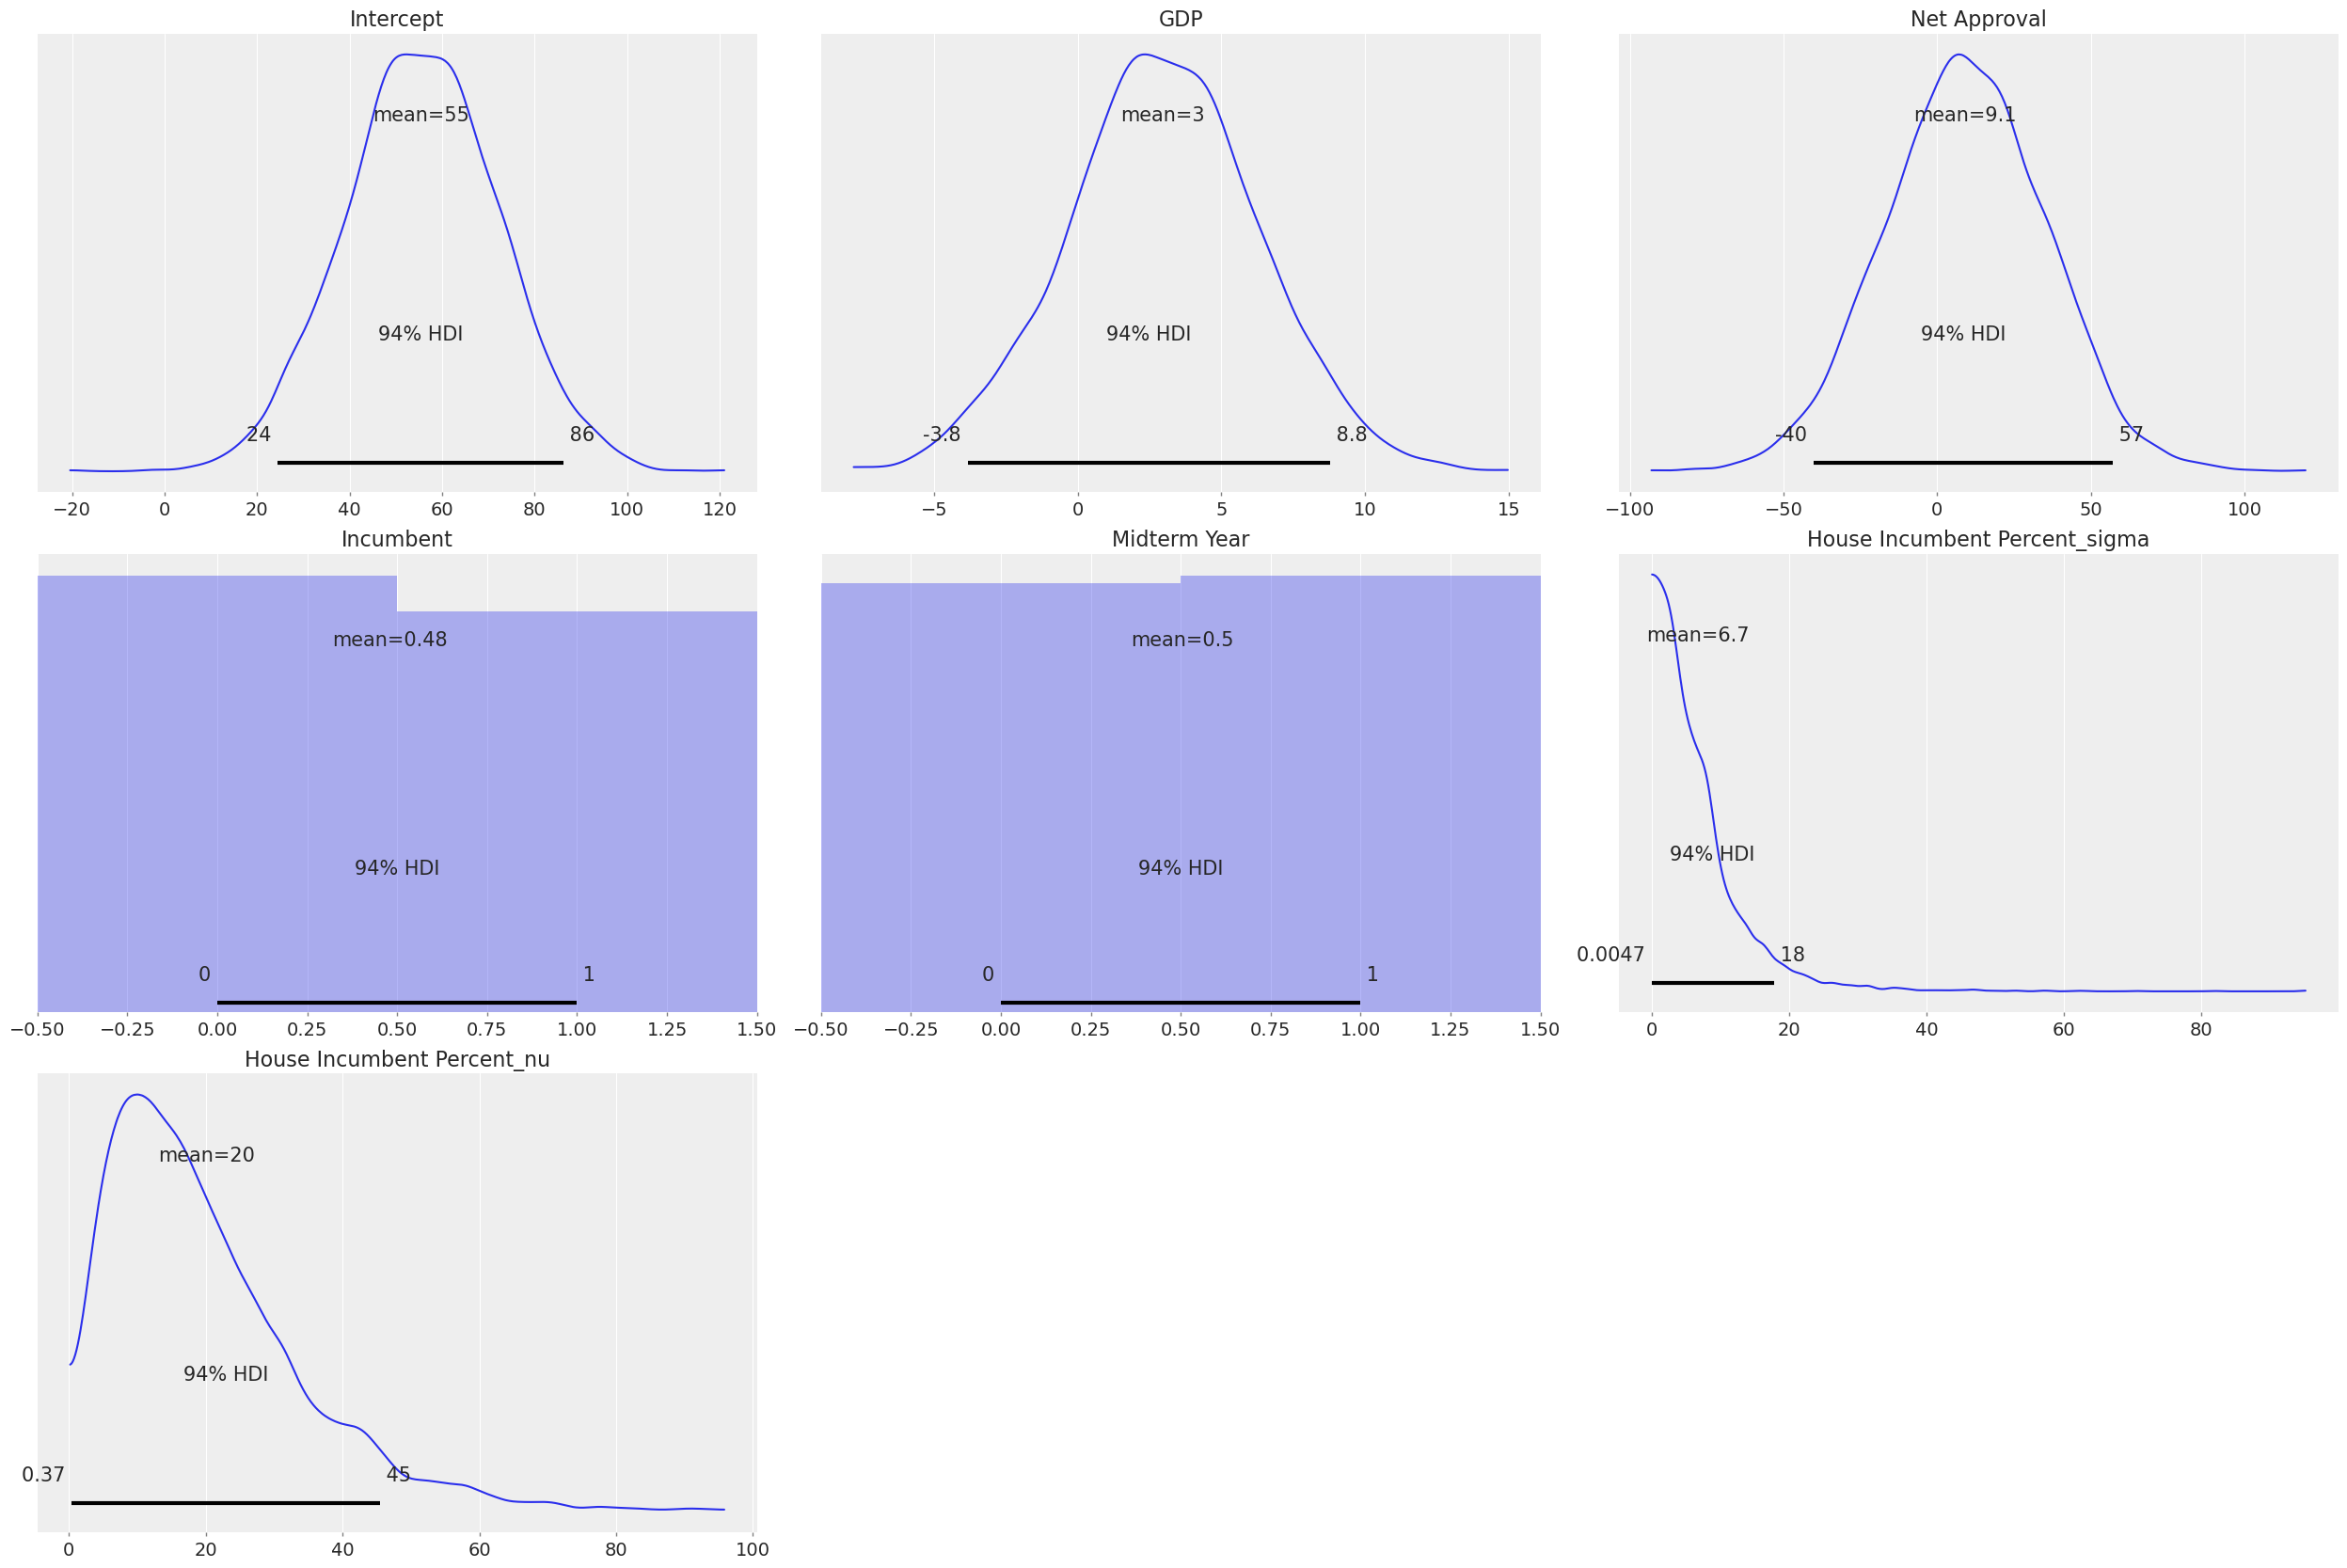

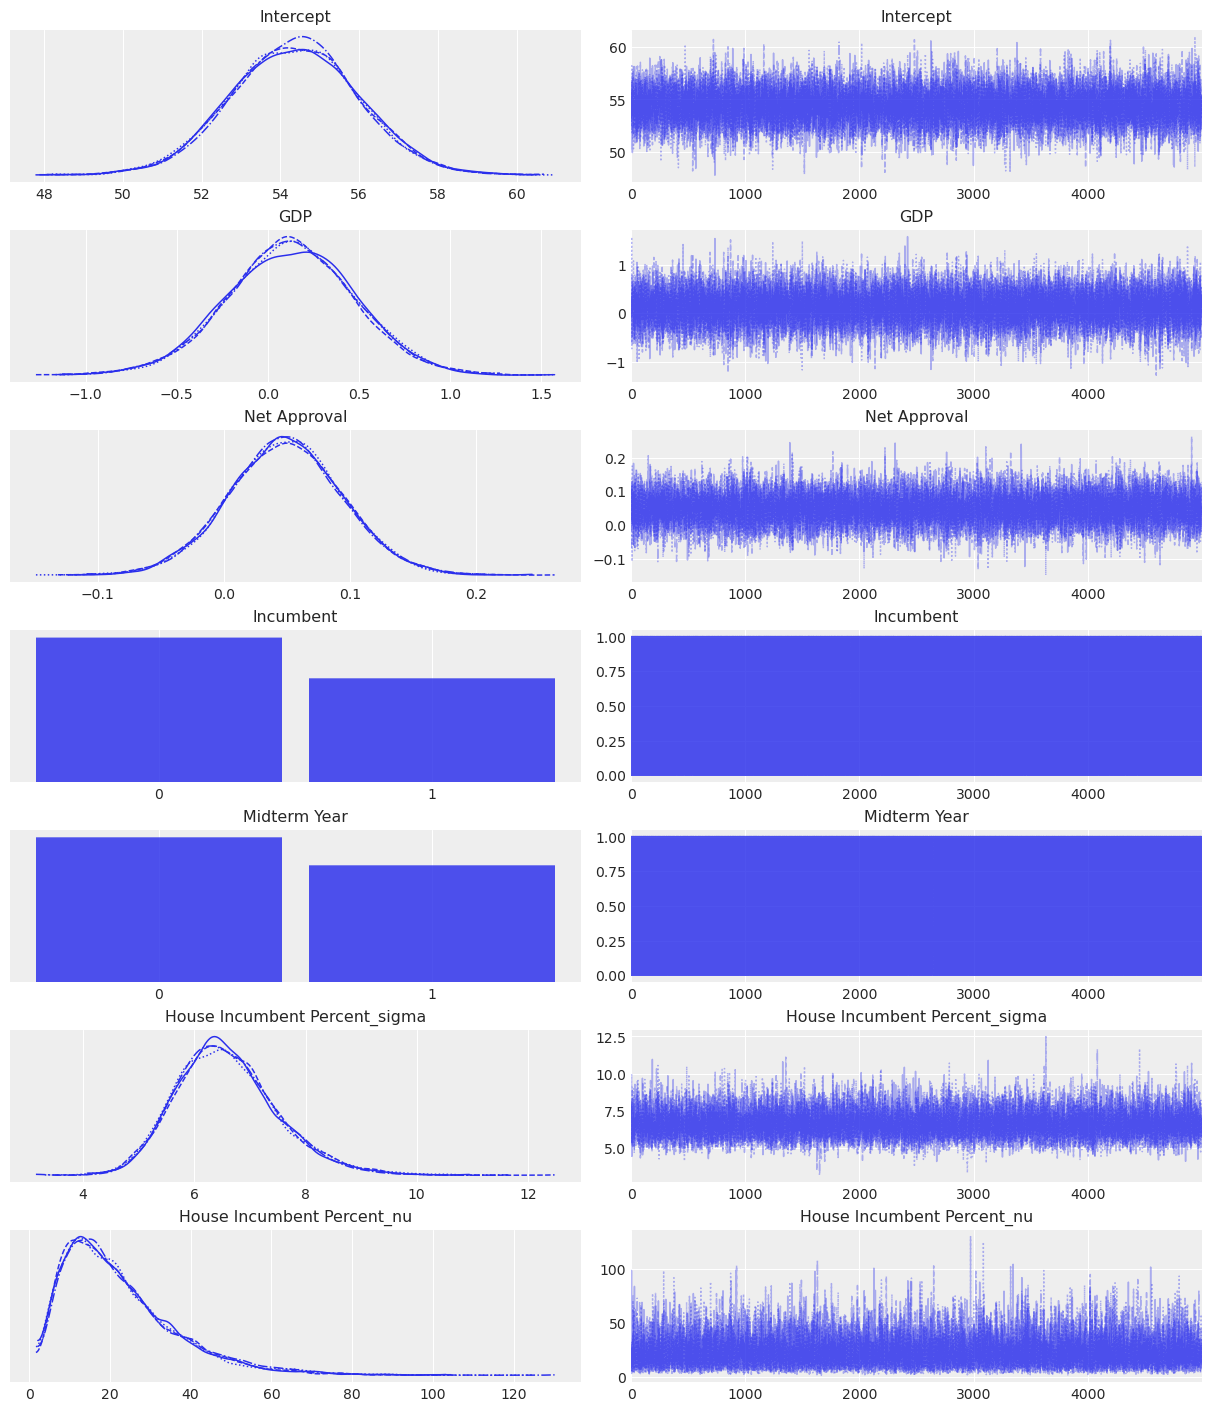

In [74]:
house_tfc_priors = {'Incumbent': Prior('Bernoulli', p=compiled_data['Incumbent'].sum()/len(compiled_data['Incumbent'])),
                    'GDP': normal_prior('GDP'),
                    "Net Approval": normal_prior("Net Approval"),
                    'Midterm Year': Prior('Bernoulli', p=.5),
                    }
#model = Model('p(Result, n) ~ GDP + "Net Approval" + Incumbent', compiled_data, family='binomial')
house_tfc_model = Model('"House Incumbent Percent" ~ GDP + "Net Approval" + Incumbent + "Midterm Year"', compiled_data, priors=house_tfc_priors, dropna=True, family='t')
print(house_tfc_model)
house_tfc_model_results = house_tfc_model.fit(draws=5000)
print(house_tfc_model_results)
house_tfc_model.plot_priors()
az.plot_trace(house_tfc_model_results)
house_tfc_summary = az.summary(house_tfc_model_results)
house_tfc_summary

In [78]:
house_tfc_means = house_tfc_summary['mean']
compiled_data['House TFC Learned Prediction'] = house_tfc_means['Intercept'] + house_tfc_means['GDP']*compiled_data['GDP'] +house_tfc_means['Net Approval']*compiled_data['Net Approval'] + house_tfc_means['Incumbent']*compiled_data['Incumbent']

compiled_data['House TFC Learned Prediction'].head()

1948    54.746742
1950    55.004467
1952    53.963779
1954    56.130819
1956    57.781671
Name: House TFC Learned Prediction, dtype: float64

In [80]:
from sklearn.metrics import mean_squared_error
naive_house_tfc_mse = mean_squared_error(compiled_data['House Incumbent Percent'], compiled_data['Time For Change Prediction'], squared=False)
learned_house_tfc_mse = mean_squared_error(compiled_data['House Incumbent Percent'], compiled_data['House TFC Learned Prediction'], squared=False)
print({'Naive House Time for Change': naive_house_tfc_mse, 'Learned House Time for Change': learned_house_tfc_mse})

{'Naive House Time for Change': 8.098277077211696, 'Learned House Time for Change': 6.4941436035882765}


Our learned house model is definitely more accurate than just the naive House Time for Change model,
but its mean squared error is half as good as our presidential model's.

That being said, the US House election is not one singular, popular vote election in the
same sense as the computation of the US President Popular Vote.
I suspect we could train 435 separate models (one for each house district) and get
fairly accurate predictions in each.